## Simulación

In [762]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from collections import defaultdict

In [763]:
random.seed(42)

class MatchSimulation:
    def __init__(self, home_players_dict, away_players_dict,home_team = 'Custom Home Team', away_team='Custom Away Team'):
        self.home_team = home_team
        self.away_team = away_team

        self.home_players = home_players_dict
        self.away_players = away_players_dict
        
        self.match_duration = random.randint(100,110)
        
        self.base_path = '/Users/luisalawson/Downloads/data 2'
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.interceptions = {'home': 0, 'away': 0}
        self.passes = {'home': 0, 'away': 0}
        self.shots = {'home': 0, 'away': 0}

        self.home_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))
            
        }
        self.away_team_matrixes = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10)),
            'goalkeeper_matrix': np.zeros((10,10))  
        }

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.flip(matrix, axis=(0, 1))

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """Buscamos las matrices individuales (para armar al equipo)"""
        if matrix_name != 'pass_transition_matrix':
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.csv')
            matrix = np.loadtxt(matrix_path, delimiter=',')
        else:
            matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
            matrix = np.load(matrix_path)
        return matrix
    
    def mirror_pass_transition_matrix(self,matrix):
        mirrored_matrix = np.flip(matrix, axis=(1, 3))
        mirrored_matrix = np.flip(mirrored_matrix, axis=(0, 2))
        
        return mirrored_matrix
    def aggregate_team_matrices(self, team):
        """Sumamos las matrices para el equipo especificado"""
        if team == 'home':
            for team_name, players in self.home_players.items():
                for player_name, _ in players:  
                    self.home_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.home_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.home_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.home_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.home_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.home_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.home_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix') 
                    self.home_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.home_team_matrixes['goalkeeper_matrix'] = self.mirror_matrix(self.home_team_matrixes['goalkeeper_matrix'])
           
        elif team == 'away':
            for team_name, players in self.away_players.items():
                for player_name, _ in players:  
                    self.away_team_matrixes['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
                    self.away_team_matrixes['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
                    self.away_team_matrixes['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
                    self.away_team_matrixes['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
                    self.away_team_matrixes['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
                    self.away_team_matrixes['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
                    self.away_team_matrixes['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  
                    self.away_team_matrixes['goalkeeper_matrix'] += self.load_player_matrix(team_name, player_name, 'goalkeeper_matrix') 
            
            self.away_team_matrixes['pass_transition_matrix'] = self.mirror_pass_transition_matrix(self.away_team_matrixes['pass_transition_matrix'])
            self.away_team_matrixes['pass_matrix'] = self.mirror_matrix(self.away_team_matrixes['pass_matrix'])
            self.away_team_matrixes['shot_matrix'] = self.mirror_matrix(self.away_team_matrixes['shot_matrix'])
            self.away_team_matrixes['defense_matrix'] = self.mirror_matrix(self.away_team_matrixes['defense_matrix'])
            self.away_team_matrixes['goal_matrix'] = self.mirror_matrix(self.away_team_matrixes['goal_matrix'])
            self.away_team_matrixes['error_matrix'] = self.mirror_matrix(self.away_team_matrixes['error_matrix'])
            self.away_team_matrixes['out_matrix'] = self.mirror_matrix(self.away_team_matrixes['out_matrix'])
           
        else:
            print(f'Error con el equipo: {team}')


    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""
        self.aggregate_team_matrices('home')
        
        self.aggregate_team_matrices('away')
        

    
    def select_event(self, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""
        if self.current_team =='home':
            pass_probabilities = self.home_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)

            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.home_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.home_team_matrixes['error_matrix'][current_x, current_y] 
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            goal_probability_ = self.home_team_matrixes['goal_matrix'][current_x, current_y]
            goal_probability = goal_probability_ if not np.isnan(goal_probability_) else 0
            shot_probability_ = (self.home_team_matrixes['shot_matrix'][current_x, current_y]) 
            shot_probability = shot_probability_ if not np.isnan(shot_probability_)  else 0
            out_probability_ = self.home_team_matrixes['out_matrix'][current_x, current_y]
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
        
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability + goal_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob,
                                goal_probability/total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out', 'goal']

            selected_event = np.random.choice(events, p=normalized_probs)

        else:
            pass_probabilities = self.away_team_matrixes['pass_transition_matrix'][current_x, current_y]
            prob_sum = np.sum(pass_probabilities)
            
            if prob_sum > 0:
                pass_probabilities = pass_probabilities / prob_sum
            else:
                pass_probabilities = np.ones_like(pass_probabilities) / pass_probabilities.size
            possible_positions = [(i, j) for i in range(10) for j in range(10)]

            next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
            next_position = possible_positions[next_position_index]

            pass_probability_ = self.away_team_matrixes['pass_matrix'][current_x, current_y] 
            pass_probability = pass_probability_ if not np.isnan(pass_probability_) else 0
            defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
            defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
            error_probability_ = self.away_team_matrixes['error_matrix'][current_x, current_y] 
            error_probability = error_probability_ if not np.isnan(error_probability_) else 0
            goal_probability_ = self.away_team_matrixes['goal_matrix'][current_x, current_y]
            goal_probability = goal_probability_ if not np.isnan(goal_probability_) else 0
            shot_probability_ = (self.away_team_matrixes['shot_matrix'][current_x, current_y]) 
            shot_probability = shot_probability_ if not np.isnan(shot_probability_) else 0
            out_probability_ = self.away_team_matrixes['out_matrix'][current_x, current_y] 
            out_probability = out_probability_ if not np.isnan(out_probability_) else 0
            
           
            total_prob = pass_probability + defense_probability + error_probability + shot_probability  + out_probability + goal_probability
            normalized_probs = [pass_probability / total_prob, 
                                defense_probability / total_prob, 
                                error_probability / total_prob, 
                                shot_probability / total_prob,
                                out_probability / total_prob,
                                goal_probability/total_prob
            ]
        

            events = ['pass', 'interception', 'error', 'shot', 'out', 'goal']
            selected_event = np.random.choice(events, p=normalized_probs)

        return selected_event, next_position,self.current_team

    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def restart_from_middle(self):
        self.ball_position =[5,5]

    def step(self):
        events_per_minute = random.randint(8,12)
        for _ in range(events_per_minute):
            # print(f'Equipo posesion: {self.current_team}')
            current_position = tuple(self.ball_position)
            current_x, current_y = current_position
            current_event, next_position, team = self.select_event(current_x, current_y)

            if current_event == 'pass':
                # print(f'Pase desde {current_position}')
                self.passes[team] += 1
                self.ball_position = next_position

            elif current_event == 'error':
                # print(f'Error en {current_position}')
                self.ball_position = current_position
                self.change_possession()

            elif current_event == 'interception':
                # print(f'Intercepcion en {current_position}')
                self.ball_position = current_position
                if team == 'home':
                    self.interceptions['away'] += 1
                else:
                    self.interceptions['home'] += 1
                self.change_possession()

            elif current_event == 'shot':
                # print(f'Tiro mal desde {current_position}')
                self.shots[team] += 1
                self.change_possession()
                self.restart_from_sideline(current_position)
            
            elif current_event=='goal':
                # print(f'Tiro al arco desde {current_position}')
                goal_scored = self.shoot_ball_new(current_x, current_y)
                self.shots[team] += 1
                if goal_scored:
                    # print('Gol')
                    self.score[team] += 1
                    self.change_possession()
                    self.restart_from_middle()
                else:
                    self.change_possession()

            elif current_event == 'out':
                # print(f'Fuera desde {current_position}')
                self.change_possession()
                self.restart_from_sideline(current_position)

        self.mins_played += 1

    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        if x <= 4: 
            new_x = 0
        else:  
            new_x = 9
        if y <= 4:  
            new_y = 0
        else:  
            new_y = 9
        self.ball_position = [new_x, new_y]

    def shoot_ball_new(self, current_x, current_y):
        if self.current_team == 'home':
            if self.ball_position[0] < 5:
                return False
            save_prob_home_ = (self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
            save_prob_home = save_prob_home_ if not np.isnan(save_prob_home_) else 0
            normalized_probs = [ 1-save_prob_home, save_prob_home] 
            events = ['goal', 'save']
            selected_event = np.random.choice(events, p=normalized_probs)
            if selected_event == 'goal':
                return True
            else:
                return False
        else:
            if self.ball_position[0] > 5:
                return False
            save_prob_away_ = (self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
            save_prob_away = save_prob_away_ if not np.isnan(save_prob_away_) else 0
            normalized_probs = [ 1-save_prob_away, save_prob_away] 
            events = ['goal', 'save']
            selected_event = np.random.choice(events, p=normalized_probs)
            if selected_event == 'goal':
                return True
            else:
                return False
            
    # def shoot_ball(self, current_x, current_y):
    #         """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
    #         if self.current_team == 'home':
    #             goal_probability_home = (self.home_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
    #             goal_probability_total_home_ = np.sum(self.home_team_matrixes['goal_matrix'] * self.match_duration)
    #             goal_probability_total_home = goal_probability_total_home_ if goal_probability_total_home_>=1 else 1                
    #             goal_prob_home = goal_probability_home /goal_probability_total_home

    #             save_prob_home = (self.away_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
                
    
    #             defense_probability_ = self.away_team_matrixes['defense_matrix'][current_x, current_y]
    #             defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
    #             defense_probability_total_home = np.sum(self.away_team_matrixes['defense_matrix'] * self.match_duration)
    #             defense_probability = defense_probability_/defense_probability_total_home

    #             total_prob = goal_prob_home*(1-(defense_probability)) + (save_prob_home)
                
    #             if total_prob == 0:
    #                 return False
                
    #             normalized_probs = [(goal_prob_home*(1-(defense_probability))) / total_prob, 
    #                                 (save_prob_home) / total_prob]
                
    #             events = ['goal', 'save']
    #             selected_event = np.random.choice(events, p=normalized_probs)
    #             if selected_event == 'goal':
    #                 return True
    #             else:
    #                 return False
            
    #         if self.current_team == 'away':
    #             goal_probability_away = (self.away_team_matrixes['goal_matrix'][current_x, current_y]) * self.match_duration
    #             goal_probability_total_away_ = np.sum(self.away_team_matrixes['goal_matrix'] * self.match_duration)
    #             goal_probability_total_away = goal_probability_total_away_ if goal_probability_total_away_>=1 else 1
    #             goal_prob_away = goal_probability_away/goal_probability_total_away


    #             save_prob_away = (self.home_team_matrixes['goalkeeper_matrix'][current_x,current_y]) 
                
    #             defense_probability_ = self.home_team_matrixes['defense_matrix'][current_x, current_y]
    #             defense_probability = defense_probability_ if not np.isnan(defense_probability_) else 0
    #             defense_probability_total_home = np.sum(self.home_team_matrixes['defense_matrix'] * self.match_duration)
    #             defense_probability = defense_probability_/defense_probability_total_home

    #             total_prob = goal_prob_away*(1-(defense_probability)) + (save_prob_away)
    #             if total_prob == 0:
    #                 return False
    #             normalized_probs = [(goal_prob_away*(1-(defense_probability))) / total_prob, 
    #                                 (save_prob_away) / total_prob]
            
    #             events = ['goal', 'save']
    #             selected_event = np.random.choice(events, p=normalized_probs)

    #             if selected_event == 'goal':
    #                 return True
    #             else:
    #                 return False
                
    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            # print(f'Minuto: {self.mins_played} ------- ')
            self.step()
        
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.shots['home'],
            'tiros_visitante': self.shots['away'],
            'pases_local': self.passes['home'],
            'pases_visitante': self.passes['away'],
            'quites_local': self.interceptions['home'],
            'quites_visitante': self.interceptions['away']
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [764]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Downloads/'
    team_data_path = os.path.join(base_path, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.sort_values(by='Starting_XI', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        return None
    except Exception as e:
        return None

In [765]:
def get_team_players(team):
    base_path = '/Users/luisalawson/Downloads/'
    team_data_path = os.path.join(base_path, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.sort_values(by='Starting_XI', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [ ]:
def choose_teams(teams_list, players_data):
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1
    

            if 0 <= team_index < len(teams_list):
                team_name = teams_list[team_index]
                available_players = [player for player in players_data[team_name] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_name}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        
                        break
                    elif 0 <= player_index < len(available_players):
                        players_dict[team_name].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a tu equipo.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return players_dict

In [767]:
teams_list = ['Manchester United', 'Manchester City', 'Chelsea', 'Arsenal',
       'Tottenham Hotspur', 'Everton', 'Liverpool',
       'West Bromwich Albion', 'Swansea City', 'West Ham United',
       'Norwich City', 'Fulham', 'Stoke City', 'Southampton',
       'Aston Villa', 'Newcastle United', 'Sunderland', 'Wigan Athletic',
       'Reading', 'Queens Park Rangers']

In [768]:
players_dict = defaultdict(list)

for team in teams_list:
    players = get_team_players(team)
    if players:  
        players_dict[team] = players

## Completo

In [769]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [ ]:
from itertools import combinations
import pandas as pd

def simulate_all_matches(teams_list, players_data):

    matches = list(combinations(teams_list, 2))  
    results = []  
    all_matches_df = pd.DataFrame()  

    initial_11_dict = {team: get_initial_11(team) for team in teams_list}

    for team, initial_11 in initial_11_dict.items():
        print(f"Jugadores iniciales de {team}: {initial_11}")

    for team1, team2 in matches:
        team1_players = {team1: [(player, 'full_period') for player in initial_11_dict[team1]]}
        team2_players = {team2: [(player, 'full_period') for player in initial_11_dict[team2]]}
        
        print(f"\nSimulando partido entre {team1} y {team2}...")

        match_result_df = simulate_matches(10, team1_players, team2_players)
        
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        match_result_df['match'] = f'{team1} vs {team2}'

        all_matches_df = pd.concat([all_matches_df, match_result_df], ignore_index=True)

        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  
        loss_pct_team2 = win_pct_team1

        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        results.append(df_transposed)

    all_results = pd.concat(results, keys=[f'{team1} vs {team2}' for team1, team2 in matches])

    return all_matches_df, all_results

In [771]:
all_matches_df, all_results = simulate_all_matches(teams_list, players_dict)

Jugadores iniciales de Manchester United: ['van Persie, Robin', 'Carrick, Michael', 'Evra, Patrice', 'Welbeck, Danny', 'de Gea, David', 'Rooney, Wayne', 'Valencia, Luis Antonio', 'Evans, Jonny', 'Ferdinand, Rio', 'Cleverley, Tom', 'Giggs, Ryan']
Jugadores iniciales de Manchester City: ['Hart, Joe', 'Aguero, Sergio', 'Toure, Gnegneri Yaya', 'Silva, David', 'Dzeko, Edin', 'Lescott, Joleon', 'Barry, Gareth', 'Nasri, Samir', 'Richards, Micah', 'Clichy, Gael', 'Kompany, Vincent']
Jugadores iniciales de Chelsea: ['Mata, Juan', 'dos Santos Emboada Junior, Oscar', 'Hazard, Eden', 'Santos do Nascimento, Ramires', 'Cech, Petr', 'Torres, Fernando', 'Ivanovic, Branislav', 'Luiz Moreira Marinho, David', 'Cole, Ashley', 'Lampard, Frank', 'Cahill, Gary']
Jugadores iniciales de Arsenal: ['Cazorla, Santiago', 'Podolski, Lukas', 'Walcott, Theo', 'Giroud, Olivier', 'Ramsey, Aaron', 'Mertesacker, Per', 'Arteta, Mikel', 'Vermaelen, Thomas', 'Szczesny, Wojciech', 'Gibbs, Kieran', 'Sagna, Bacary']
Jugadores 

Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.20partido/s]



Simulando partido entre Manchester United y Chelsea...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.79partido/s]



Simulando partido entre Manchester United y Arsenal...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.28partido/s]



Simulando partido entre Manchester United y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.81partido/s]



Simulando partido entre Manchester United y Everton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.07partido/s]



Simulando partido entre Manchester United y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.04partido/s]



Simulando partido entre Manchester United y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.94partido/s]



Simulando partido entre Manchester United y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.10partido/s]



Simulando partido entre Manchester United y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.18partido/s]



Simulando partido entre Manchester United y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.75partido/s]



Simulando partido entre Manchester United y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.56partido/s]



Simulando partido entre Manchester United y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.59partido/s]



Simulando partido entre Manchester United y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.86partido/s]



Simulando partido entre Manchester United y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.21partido/s]



Simulando partido entre Manchester United y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.90partido/s]



Simulando partido entre Manchester United y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.87partido/s]



Simulando partido entre Manchester United y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.49partido/s]



Simulando partido entre Manchester United y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.96partido/s]



Simulando partido entre Manchester United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.81partido/s]



Simulando partido entre Manchester City y Chelsea...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.57partido/s]



Simulando partido entre Manchester City y Arsenal...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.54partido/s]



Simulando partido entre Manchester City y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.11partido/s]



Simulando partido entre Manchester City y Everton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.66partido/s]



Simulando partido entre Manchester City y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.48partido/s]



Simulando partido entre Manchester City y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.02partido/s]



Simulando partido entre Manchester City y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:00<00:00, 10.02partido/s]



Simulando partido entre Manchester City y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:00<00:00, 10.24partido/s]



Simulando partido entre Manchester City y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.29partido/s]



Simulando partido entre Manchester City y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.43partido/s]



Simulando partido entre Manchester City y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.83partido/s]



Simulando partido entre Manchester City y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.33partido/s]



Simulando partido entre Manchester City y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.26partido/s]



Simulando partido entre Manchester City y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.91partido/s]



Simulando partido entre Manchester City y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.99partido/s]



Simulando partido entre Manchester City y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.85partido/s]



Simulando partido entre Manchester City y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.69partido/s]



Simulando partido entre Manchester City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.76partido/s]



Simulando partido entre Chelsea y Arsenal...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.30partido/s]



Simulando partido entre Chelsea y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.00partido/s]



Simulando partido entre Chelsea y Everton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.65partido/s]



Simulando partido entre Chelsea y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.38partido/s]



Simulando partido entre Chelsea y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.56partido/s]



Simulando partido entre Chelsea y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.12partido/s]



Simulando partido entre Chelsea y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.04partido/s]



Simulando partido entre Chelsea y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.23partido/s]



Simulando partido entre Chelsea y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.99partido/s]



Simulando partido entre Chelsea y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.86partido/s]



Simulando partido entre Chelsea y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.94partido/s]



Simulando partido entre Chelsea y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.14partido/s]



Simulando partido entre Chelsea y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.37partido/s]



Simulando partido entre Chelsea y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.97partido/s]



Simulando partido entre Chelsea y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.13partido/s]



Simulando partido entre Chelsea y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.85partido/s]



Simulando partido entre Chelsea y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.09partido/s]



Simulando partido entre Arsenal y Tottenham Hotspur...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.44partido/s]



Simulando partido entre Arsenal y Everton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.51partido/s]



Simulando partido entre Arsenal y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.38partido/s]



Simulando partido entre Arsenal y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.01partido/s]



Simulando partido entre Arsenal y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.67partido/s]



Simulando partido entre Arsenal y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.69partido/s]



Simulando partido entre Arsenal y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.76partido/s]



Simulando partido entre Arsenal y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.70partido/s]



Simulando partido entre Arsenal y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.31partido/s]



Simulando partido entre Arsenal y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.78partido/s]



Simulando partido entre Arsenal y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.42partido/s]



Simulando partido entre Arsenal y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.29partido/s]



Simulando partido entre Arsenal y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.41partido/s]



Simulando partido entre Arsenal y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.44partido/s]



Simulando partido entre Arsenal y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.36partido/s]



Simulando partido entre Arsenal y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  5.35partido/s]



Simulando partido entre Tottenham Hotspur y Everton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.46partido/s]



Simulando partido entre Tottenham Hotspur y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.39partido/s]



Simulando partido entre Tottenham Hotspur y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.17partido/s]



Simulando partido entre Tottenham Hotspur y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.80partido/s]



Simulando partido entre Tottenham Hotspur y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.77partido/s]



Simulando partido entre Tottenham Hotspur y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.77partido/s]



Simulando partido entre Tottenham Hotspur y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.63partido/s]



Simulando partido entre Tottenham Hotspur y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.76partido/s]



Simulando partido entre Tottenham Hotspur y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.00partido/s]



Simulando partido entre Tottenham Hotspur y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.23partido/s]



Simulando partido entre Tottenham Hotspur y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.94partido/s]



Simulando partido entre Tottenham Hotspur y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.53partido/s]



Simulando partido entre Tottenham Hotspur y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.38partido/s]



Simulando partido entre Tottenham Hotspur y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.28partido/s]



Simulando partido entre Tottenham Hotspur y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.84partido/s]



Simulando partido entre Everton y Liverpool...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.01partido/s]



Simulando partido entre Everton y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.52partido/s]



Simulando partido entre Everton y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.42partido/s]



Simulando partido entre Everton y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.71partido/s]



Simulando partido entre Everton y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.18partido/s]



Simulando partido entre Everton y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.16partido/s]



Simulando partido entre Everton y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.36partido/s]



Simulando partido entre Everton y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.03partido/s]



Simulando partido entre Everton y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.61partido/s]



Simulando partido entre Everton y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.00partido/s]



Simulando partido entre Everton y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.72partido/s]



Simulando partido entre Everton y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.33partido/s]



Simulando partido entre Everton y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.23partido/s]



Simulando partido entre Everton y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.04partido/s]



Simulando partido entre Liverpool y West Bromwich Albion...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.79partido/s]



Simulando partido entre Liverpool y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.08partido/s]



Simulando partido entre Liverpool y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.20partido/s]



Simulando partido entre Liverpool y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.41partido/s]



Simulando partido entre Liverpool y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.76partido/s]



Simulando partido entre Liverpool y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.19partido/s]



Simulando partido entre Liverpool y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.59partido/s]



Simulando partido entre Liverpool y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.83partido/s]



Simulando partido entre Liverpool y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.22partido/s]



Simulando partido entre Liverpool y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.41partido/s]



Simulando partido entre Liverpool y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.82partido/s]



Simulando partido entre Liverpool y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.47partido/s]



Simulando partido entre Liverpool y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.99partido/s]



Simulando partido entre West Bromwich Albion y Swansea City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.95partido/s]



Simulando partido entre West Bromwich Albion y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.25partido/s]



Simulando partido entre West Bromwich Albion y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.87partido/s]



Simulando partido entre West Bromwich Albion y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:00<00:00, 10.23partido/s]



Simulando partido entre West Bromwich Albion y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.64partido/s]



Simulando partido entre West Bromwich Albion y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.49partido/s]



Simulando partido entre West Bromwich Albion y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:00<00:00, 10.06partido/s]



Simulando partido entre West Bromwich Albion y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.99partido/s]



Simulando partido entre West Bromwich Albion y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.34partido/s]



Simulando partido entre West Bromwich Albion y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.21partido/s]



Simulando partido entre West Bromwich Albion y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.45partido/s]



Simulando partido entre West Bromwich Albion y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.79partido/s]



Simulando partido entre Swansea City y West Ham United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.41partido/s]



Simulando partido entre Swansea City y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.24partido/s]



Simulando partido entre Swansea City y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.21partido/s]



Simulando partido entre Swansea City y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  5.69partido/s]



Simulando partido entre Swansea City y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.30partido/s]



Simulando partido entre Swansea City y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.97partido/s]



Simulando partido entre Swansea City y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.95partido/s]



Simulando partido entre Swansea City y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.04partido/s]



Simulando partido entre Swansea City y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.32partido/s]



Simulando partido entre Swansea City y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.85partido/s]



Simulando partido entre Swansea City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.39partido/s]



Simulando partido entre West Ham United y Norwich City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.70partido/s]



Simulando partido entre West Ham United y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.44partido/s]



Simulando partido entre West Ham United y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.45partido/s]



Simulando partido entre West Ham United y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.69partido/s]



Simulando partido entre West Ham United y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.17partido/s]



Simulando partido entre West Ham United y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.14partido/s]



Simulando partido entre West Ham United y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.82partido/s]



Simulando partido entre West Ham United y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.67partido/s]



Simulando partido entre West Ham United y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.52partido/s]



Simulando partido entre West Ham United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.37partido/s]



Simulando partido entre Norwich City y Fulham...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.66partido/s]



Simulando partido entre Norwich City y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.92partido/s]



Simulando partido entre Norwich City y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.96partido/s]



Simulando partido entre Norwich City y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.59partido/s]



Simulando partido entre Norwich City y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.16partido/s]



Simulando partido entre Norwich City y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.33partido/s]



Simulando partido entre Norwich City y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.65partido/s]



Simulando partido entre Norwich City y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.39partido/s]



Simulando partido entre Norwich City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.23partido/s]



Simulando partido entre Fulham y Stoke City...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.59partido/s]



Simulando partido entre Fulham y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.55partido/s]



Simulando partido entre Fulham y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.11partido/s]



Simulando partido entre Fulham y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.35partido/s]



Simulando partido entre Fulham y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.27partido/s]



Simulando partido entre Fulham y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.93partido/s]



Simulando partido entre Fulham y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.26partido/s]



Simulando partido entre Fulham y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.40partido/s]



Simulando partido entre Stoke City y Southampton...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.88partido/s]



Simulando partido entre Stoke City y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.95partido/s]



Simulando partido entre Stoke City y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.99partido/s]



Simulando partido entre Stoke City y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.08partido/s]



Simulando partido entre Stoke City y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.91partido/s]



Simulando partido entre Stoke City y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.94partido/s]



Simulando partido entre Stoke City y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  6.81partido/s]



Simulando partido entre Southampton y Aston Villa...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.52partido/s]



Simulando partido entre Southampton y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.62partido/s]



Simulando partido entre Southampton y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:02<00:00,  4.72partido/s]



Simulando partido entre Southampton y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.15partido/s]



Simulando partido entre Southampton y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.01partido/s]



Simulando partido entre Southampton y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.52partido/s]



Simulando partido entre Aston Villa y Newcastle United...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.67partido/s]



Simulando partido entre Aston Villa y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.19partido/s]



Simulando partido entre Aston Villa y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.56partido/s]



Simulando partido entre Aston Villa y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.98partido/s]



Simulando partido entre Aston Villa y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.23partido/s]



Simulando partido entre Newcastle United y Sunderland...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.90partido/s]



Simulando partido entre Newcastle United y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.80partido/s]



Simulando partido entre Newcastle United y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  8.74partido/s]



Simulando partido entre Newcastle United y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.99partido/s]



Simulando partido entre Sunderland y Wigan Athletic...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.87partido/s]



Simulando partido entre Sunderland y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.13partido/s]



Simulando partido entre Sunderland y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.78partido/s]



Simulando partido entre Wigan Athletic y Reading...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.79partido/s]



Simulando partido entre Wigan Athletic y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.62partido/s]



Simulando partido entre Reading y Queens Park Rangers...


Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  9.79partido/s]


In [772]:
all_results.to_csv('/Users/luisalawson/Desktop/PRUEBA_20_NOV.csv')

In [773]:
all_matches_df.to_csv('/Users/luisalawson/Desktop/PRUEBA_20_NOV_DISTRIBUCIONES.csv')

In [774]:
all_results = pd.read_csv('/Users/luisalawson/Desktop/PRUEBA_20_NOV.csv')

In [775]:
all_results.rename(columns={'Unnamed: 0': 'Match'}, inplace=True)  
all_results.set_index('Match', inplace=True)  

## Simulacion de todos los partidos para armar el ranking base teniendo en cuenta las probas de win/loss/tie

In [776]:
import pandas as pd
from collections import defaultdict

def simulate_season_ranking(all_results):
    points_table = defaultdict(float)
    for match, probabilities in all_results.groupby('Match'):
        teams = match.split(" vs ")
        team1, team2 = teams[0], teams[1]
        
        win_prob_team1 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team1].values[0]
        tie_prob = probabilities.loc[probabilities['Unnamed: 1'] == 'tie%', team1].values[0]  
        win_prob_team2 = probabilities.loc[probabilities['Unnamed: 1'] == 'win%', team2].values[0]
        
        expected_points_team1 = 3 * (win_prob_team1 / 100) + 1 * (tie_prob / 100)
        expected_points_team2 = 3 * (win_prob_team2 / 100) + 1 * (tie_prob / 100)

        points_table[team1] += expected_points_team1
        points_table[team2] += expected_points_team2

    ranking_df = pd.DataFrame(list(points_table.items()), columns=['Team', 'Points'])
    ranking_df = ranking_df.sort_values(by='Points', ascending=False).reset_index(drop=True)
    ranking_df.index += 1  
    return ranking_df

In [777]:
final_ranking = simulate_season_ranking(all_results)

In [778]:
final_ranking

,Team,Points
1,Arsenal,43.4
2,Everton,43.1
3,Chelsea,37.6
4,Liverpool,34.7
5,Tottenham Hotspur,33.8
6,Southampton,32.7
7,West Bromwich Albion,31.5
8,Manchester City,31.3
9,West Ham United,27.9
10,Stoke City,26.6


## Validamos

In [779]:
ranking = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')

final_ranking = final_ranking.merge(
    ranking[['Equipo', 'Posicion', 'Puntos', 'PG', 'PE', 'PP']],  
    left_on='Team',                   
    right_on='Equipo',                
    how='left'                        
)

final_ranking = final_ranking.rename(columns={'Posicion': 'real_position'})
final_ranking = final_ranking.drop(columns=['Equipo'])
final_ranking['Points_Quintile'] = pd.qcut(final_ranking['Points'], 4, labels=False)
grouped = final_ranking.groupby('Points_Quintile')[['PG', 'PE', 'PP']].sum()
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100


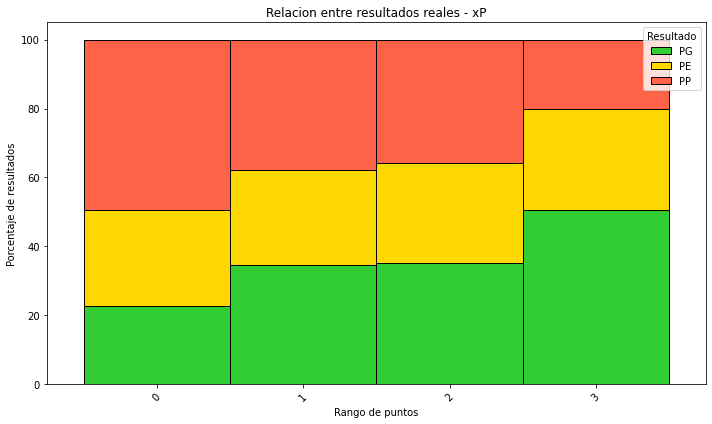

In [780]:
import matplotlib.pyplot as plt

custom_colors = [ '#32CD32','#FFD700', '#FF6347']  

ax = grouped_percentage.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=custom_colors,  
    width=1,  
    edgecolor='black' 
)

plt.title('Relacion entre resultados reales - xP')
plt.xlabel('Rango de puntos')
plt.ylabel('Porcentaje de resultados')
plt.legend(title='Resultado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

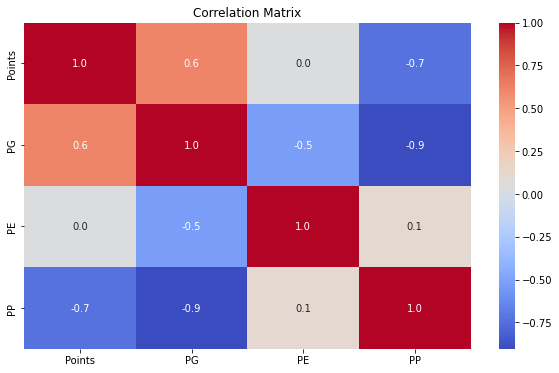

In [781]:
import seaborn as sns
correlation_matrix = final_ranking[['Points', 'PG', 'PE', 'PP']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
resultados_detallados = pd.read_csv('/Users/luisalawson/Desktop/PRUEBA_20_NOV_DISTRIBUCIONES.csv')

In [782]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_mc = resultados_detallados[(resultados_detallados['home'] == 'Manchester City') | 
                               (resultados_detallados['away'] == 'Manchester City')]
eventos = ['goles_local', 'goles_visitante', 'tiros_local', 'tiros_visitante', 
           'pases_local', 'pases_visitante', 'quites_local', 'quites_visitante']
df_eventos = df_mc[['home', 'away'] + eventos]
df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester City' else row['goles_visitante'], axis=1)
df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manchester City' else row['tiros_visitante'], axis=1)
df_eventos.loc[:, 'pases'] = df_eventos.apply(lambda row: row['pases_local'] if row['home'] == 'Manchester City' else row['pases_visitante'], axis=1)
df_eventos.loc[:, 'quites'] = df_eventos.apply(lambda row: row['quites_local'] if row['home'] == 'Manchester City' else row['quites_visitante'], axis=1)
eventos_dict = {'Goles': df_eventos['goles'], 'Tiros': df_eventos['tiros'], 
                'Pases': df_eventos['pases'], 'Quites': df_eventos['quites']}

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/490934485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'goles'] = df_eventos.apply(lambda row: row['goles_local'] if row['home'] == 'Manchester City' else row['goles_visitante'], axis=1)
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/490934485.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eventos.loc[:, 'tiros'] = df_eventos.apply(lambda row: row['tiros_local'] if row['home'] == 'Manchester Cit

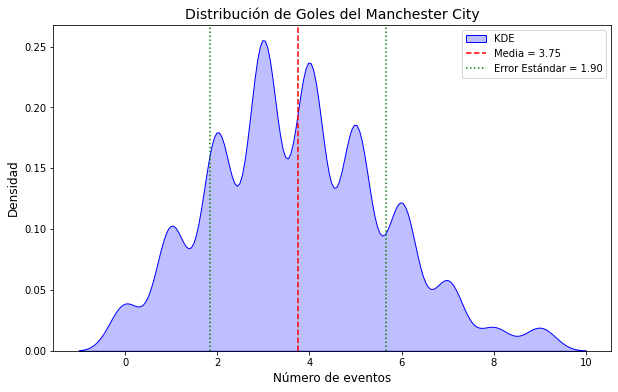

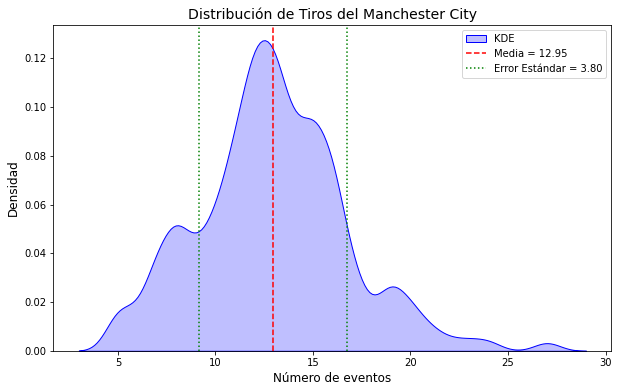

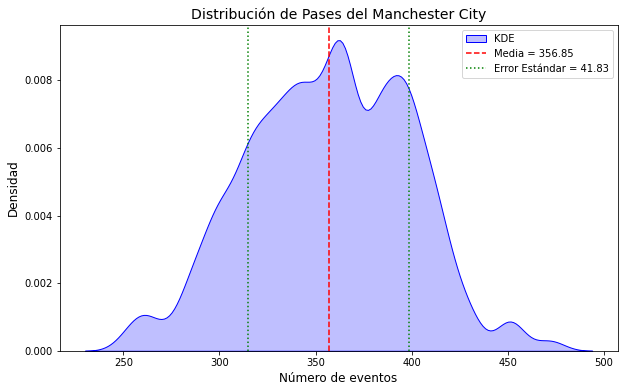

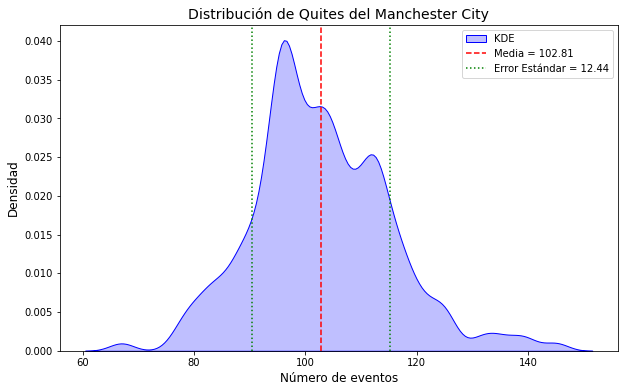

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for evento, data in eventos_dict.items():
    media = np.mean(data)
    error_estandar = np.std(data)
    
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data, fill=True, bw_adjust=0.5, color="blue", label="KDE")
    
    plt.axvline(media, color='red', linestyle='--', label=f'Media = {media:.2f}')
    plt.axvline(media - error_estandar, color='green', linestyle=':', label=f'Error Estándar = {error_estandar:.2f}')
    plt.axvline(media + error_estandar, color='green', linestyle=':', label='_nolegend_')
    
    plt.title(f'Distribución de {evento} del Manchester City', fontsize=14)
    plt.xlabel('Cantidad', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.legend(loc='upper right')
    
    plt.show()


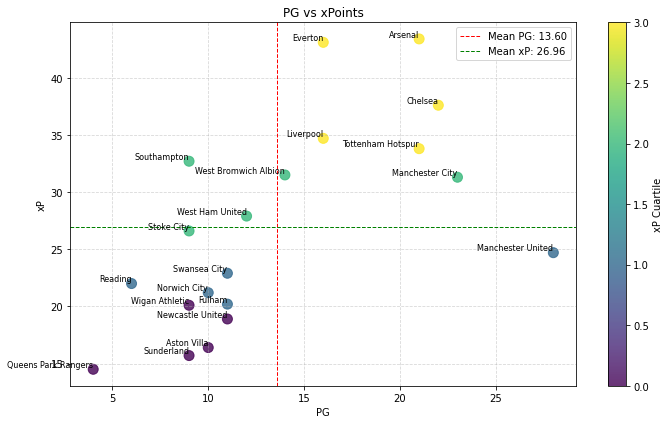

In [783]:
import matplotlib.pyplot as plt
import pandas as pd

mean_PG = final_ranking['PG'].mean()
mean_Points = final_ranking['Points'].mean()


plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_ranking['PG'], 
    final_ranking['Points'], 
    c=final_ranking['Points_Quintile'], 
    cmap='viridis', 
    s=100, 
    alpha=0.8
)

for i, row in final_ranking.iterrows():
    plt.annotate(row['Team'], (row['PG'], row['Points']), fontsize=8, ha='right', va='bottom')

plt.axvline(mean_PG, color='red', linestyle='--', linewidth=1, label=f'Mean PG: {mean_PG:.2f}')
plt.axhline(mean_Points, color='green', linestyle='--', linewidth=1, label=f'Mean xP: {mean_Points:.2f}')

plt.xlabel('PG')
plt.ylabel('xP')
plt.title('PG vs xPoints')
plt.colorbar(scatter, label='xP Cuartile') 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

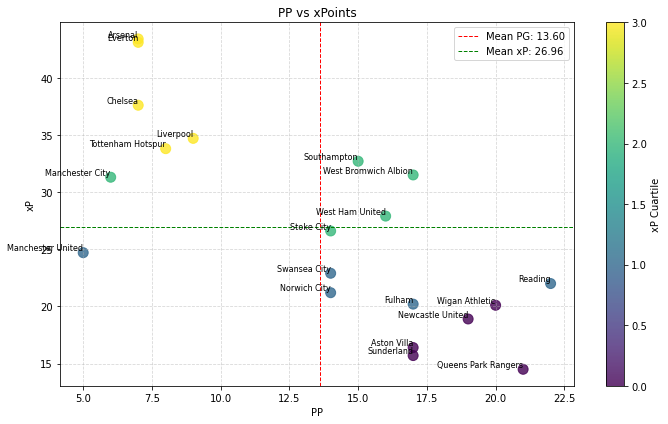

In [784]:
import matplotlib.pyplot as plt
import pandas as pd

mean_PP = final_ranking['PP'].mean()
mean_Points = final_ranking['Points'].mean()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_ranking['PP'], 
    final_ranking['Points'], 
    c=final_ranking['Points_Quintile'], 
    cmap='viridis', 
    s=100, 
    alpha=0.8
)


for i, row in final_ranking.iterrows():
    plt.annotate(row['Team'], (row['PP'], row['Points']), fontsize=8, ha='right', va='bottom')

plt.axvline(mean_PP, color='red', linestyle='--', linewidth=1, label=f'Mean PG: {mean_PP:.2f}')
plt.axhline(mean_Points, color='green', linestyle='--', linewidth=1, label=f'Mean xP: {mean_Points:.2f}')

plt.xlabel('PP')
plt.ylabel('xP')
plt.title('PP vs xPoints')
plt.colorbar(scatter, label='xP Cuartile') 
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [785]:
final_ranking['real_position'] = final_ranking['real_position'].apply(lambda x: x - 1)

In [786]:
final_ranking

,Team,Points,real_position,Puntos,PG,PE,PP,Points_Quintile
0,Arsenal,43.4,3,73,21,10,7,3
1,Everton,43.1,5,63,16,15,7,3
2,Chelsea,37.6,2,75,22,9,7,3
3,Liverpool,34.7,6,61,16,13,9,3
4,Tottenham Hotspur,33.8,4,72,21,9,8,3
5,Southampton,32.7,13,41,9,14,15,2
6,West Bromwich Albion,31.5,7,49,14,7,17,2
7,Manchester City,31.3,1,78,23,9,6,2
8,West Ham United,27.9,9,46,12,10,16,2
9,Stoke City,26.6,12,42,9,15,14,2


## Simulamos con cambio de jugadores

In [787]:
def choose_teams(teams_list, players_data):
    """
    Permite al usuario elegir un equipo completo o un equipo personalizado.
    Devuelve un diccionario en el formato: {'TeamName': [(player1, periods), (player2, periods), ...]}.
    """
    print("¿Cómo deseas elegir tu equipo?")
    print("1. Elegir un equipo completo")
    print("2. Seleccionar jugadores individuales de diferentes equipos")

    choice = input("Ingresa el número de tu elección (1 o 2): ")

    players_dict = defaultdict(list)  # Creamos el diccionario para almacenar la selección de jugadores
    team_name = ""

    if choice == '1':
        # Elegir un equipo completo
        print("Equipos disponibles:")
        for idx, team in enumerate(teams_list, start=1):
            print(f"{idx}. {team}")

        team_index = int(input("Selecciona el número del equipo que deseas elegir: ")) - 1

        if 0 <= team_index < len(teams_list):
            team_name = teams_list[team_index]
            selected_players = get_initial_11(team_name)  # Llama a la función que devuelve el equipo titular
            players_dict[team_name] = [(player, 'full_period') for player in selected_players]
            print(f"\nEquipo titular seleccionado para {team_name}: {selected_players}")
        else:
            print("Selección de equipo inválida.")

    elif choice == '2':
        # Selección de jugadores personalizados de diferentes equipos
        team_name = input("Ingresa el nombre del equipo personalizado: ")

        while sum(len(players) for players in players_dict.values()) < 11:
            print("Equipos disponibles:")
            for idx, team in enumerate(teams_list, start=1):
                print(f"{idx}. {team}")

            team_index = int(input("Selecciona el número del equipo para elegir jugadores: ")) - 1

            if 0 <= team_index < len(teams_list):
                team_origin = teams_list[team_index]
                available_players = [player for player in players_data[team_origin] 
                                     if player not in [p[0] for players in players_dict.values() for p in players]]

                while True:
                    print(f"Jugadores disponibles en {team_origin}:")
                    for idx, player in enumerate(available_players, start=1):
                        print(f"{idx}. {player}")

                    player_index = int(input("Selecciona el número del jugador que deseas agregar (o 0 para cambiar de equipo): ")) - 1

                    if player_index == -1:
                        break
                    elif 0 <= player_index < len(available_players):
                        # Agregar el jugador al equipo de origen en `players_dict`
                        players_dict[team_origin].append((available_players[player_index], 'custom_period'))
                        print(f"Jugador {available_players[player_index]} agregado a {team_origin}.")
                        print(f"Jugadores seleccionados: {sum(len(players) for players in players_dict.values())} / 11\n")

                        # Actualizar la lista de jugadores disponibles
                        available_players.pop(player_index)

                        # Si se alcanzan los 11 jugadores, salir del bucle
                        if sum(len(players) for players in players_dict.values()) == 11:
                            break
                    else:
                        print("Selección de jugador no válida.")
            else:
                print("Selección de equipo no válida.")

        if sum(len(players) for players in players_dict.values()) == 11:
            print("\nHas completado tu equipo:")
        else:
            print("\nNo has completado los 11 jugadores, pero esta es tu selección final:")
        print(players_dict)

    else:
        print("Opción inválida. Por favor, elige 1 o 2.")

    return team_name, players_dict

In [788]:
random.seed(42)
def simulate_matches(num_matches, home_players, away_players):
    results = []
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        home_team_name = list(home_players.keys())[0] if len(home_players) == 1 else None
        away_team_name = list(away_players.keys())[0] if len(away_players) == 1 else None
        if home_team_name == None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players)
        elif home_team_name != None and away_team_name == None:
            simulation = MatchSimulation(home_players, away_players, home_team=home_team_name)
        elif home_team_name == None and away_team_name != None:
            simulation = MatchSimulation(home_players, away_players, away_team=away_team_name)
        else:
            simulation = MatchSimulation(home_players, away_players, home_team= home_team_name, away_team= away_team_name)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [789]:
import pandas as pd
from collections import defaultdict

def simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results):
    if 'Match' not in all_results.columns:
        all_results.reset_index(inplace=True)

    updated_results = all_results.copy()
    results = []

    for opponent_team in teams_list:
        if opponent_team == team_name:
            continue  

        team1 = team_name
        team2 = opponent_team
        team1_players = {team1: selected_team_players[team1]}
        team2_players = {team2: [(player, 'full_period') for player in get_initial_11(team2)]}

        match_result_df = simulate_matches(10, team1_players, team2_players)
        
        match_result_df['winner'] = match_result_df.apply(
            lambda row: row['home'] if row['goles_local'] > row['goles_visitante'] else
                        row['away'] if row['goles_local'] < row['goles_visitante'] else
                        'tie', axis=1
        )

        total_games = match_result_df.shape[0]
        win_counts = match_result_df['winner'].value_counts()
        win_pct_team1 = (win_counts.get(team1, 0) / total_games) * 100
        win_pct_team2 = (win_counts.get(team2, 0) / total_games) * 100
        tie_pct = (win_counts.get('tie', 0) / total_games) * 100
        loss_pct_team1 = win_pct_team2  # La pérdida de un equipo es la victoria del otro
        loss_pct_team2 = win_pct_team1

        new_index = ['win%', 'loss%', 'tie%', 'avg_goles', 'avg_tiros', 'avg_pases', 'avg_quites'] 
        teams_current = [team1, team2]
        df_transposed = pd.DataFrame(index=new_index, columns=teams_current)
        
        df_transposed.loc['win%', team1] = win_pct_team1
        df_transposed.loc['loss%', team1] = loss_pct_team1
        df_transposed.loc['tie%', team1] = tie_pct
        df_transposed.loc['win%', team2] = win_pct_team2
        df_transposed.loc['loss%', team2] = loss_pct_team2
        df_transposed.loc['tie%', team2] = tie_pct

        df_transposed.loc['avg_goles', team1] = match_result_df['goles_local'].mean()
        df_transposed.loc['avg_goles', team2] = match_result_df['goles_visitante'].mean()
        df_transposed.loc['avg_tiros', team1] = match_result_df['tiros_local'].mean()
        df_transposed.loc['avg_tiros', team2] = match_result_df['tiros_visitante'].mean()
        df_transposed.loc['avg_pases', team1] = match_result_df['pases_local'].mean()
        df_transposed.loc['avg_pases', team2] = match_result_df['pases_visitante'].mean()
        df_transposed.loc['avg_quites', team1] = match_result_df['quites_local'].mean()
        df_transposed.loc['avg_quites', team2] = match_result_df['quites_visitante'].mean()

        match_key1 = f"{team1} vs {team2}"
        match_key2 = f"{team2} vs {team1}"
        
        if match_key1 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key1) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]
                
        elif match_key2 in updated_results['Match'].values:
            for metric in new_index:
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team1] = df_transposed.loc[metric, team1]
                updated_results.loc[(updated_results['Match'] == match_key2) & 
                                    (updated_results['Unnamed: 1'] == metric), team2] = df_transposed.loc[metric, team2]
    return updated_results

In [790]:
team_name, selected_team_players = choose_teams(teams_list, players_dict)
updated_all_results = simulate_against_all_teams(team_name, selected_team_players, teams_list, all_results)

¿Cómo deseas elegir tu equipo?
1. Elegir un equipo completo
2. Seleccionar jugadores individuales de diferentes equipos
Equipos disponibles:
1. Manchester United
2. Manchester City
3. Chelsea
4. Arsenal
5. Tottenham Hotspur
6. Everton
7. Liverpool
8. West Bromwich Albion
9. Swansea City
10. West Ham United
11. Norwich City
12. Fulham
13. Stoke City
14. Southampton
15. Aston Villa
16. Newcastle United
17. Sunderland
18. Wigan Athletic
19. Reading
20. Queens Park Rangers
Jugadores disponibles en Manchester City:
1. Hart, Joe
2. Aguero, Sergio
3. Toure, Gnegneri Yaya
4. Silva, David
5. Dzeko, Edin
6. Lescott, Joleon
7. Barry, Gareth
8. Nasri, Samir
9. Richards, Micah
10. Clichy, Gael
11. Kompany, Vincent
12. Tevez, Carlos
13. Zabaleta, Pablo
14. Kolarov, Aleksandar
15. Garcia Fernandez, Francisco Javier
16. Milner, James
17. Nastasic, Matija
18. Rodwell, Jack
19. Balotelli, Mario
20. Toure, Kolo
21. Sinclair, Scott
22. Maicon, Douglas
23. Razak, Abdul
24. Rekik, Karim
Jugador Hart, Joe ag

Simulando partidos: 100%|██████████| 10/10 [00:01<00:00,  7.50partido/s]


In [791]:
updated_all_results.to_csv('/Users/luisalawson/Downloads/PRUEBA_20_NOV_SIN_KOMPANY.csv')

In [792]:
final_ranking_Kompany = simulate_season_ranking(updated_all_results)

In [793]:
final_ranking_Kompany

,Team,Points
1,Everton,43.1
2,Arsenal,41.9
3,Chelsea,38.4
4,Liverpool,34.7
5,Tottenham Hotspur,33.7
6,Southampton,33.2
7,West Bromwich Albion,32.4
8,Manchester City,32.2
9,West Ham United,27.5
10,Stoke City,27.0


## Validando el modelo

In [794]:
df_complete = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter =';')

In [795]:
df_ManCity = df_complete[(df_complete['home_team_name'] == 'Manchester City') | 
                         (df_complete['away_team_name'] == 'Manchester City')]

In [796]:
df_ManCity_final = df_ManCity[df_ManCity['team_id']==43]

In [797]:
successful_passes = df_ManCity_final[(df_ManCity_final['description'] == 'Pass') & (df_ManCity_final['outcome'] == 1)]
failed_passes = df_ManCity_final[(df_ManCity_final['description'] == 'Pass') & (df_ManCity_final['outcome'] == 0)]
successful_interceptions = df_ManCity_final[
    (df_ManCity_final['description'].isin(['Interception', 'Tackle', 'Clearance', 'Aerial', 'Ball recovery'])) & 
    (df_ManCity_final['outcome'] == 1)
]
errors = df_ManCity_final[ ((df_ManCity_final['description'] == 'Error') & (df_ManCity_final['outcome'] == 1))
]

passes_count = successful_passes.groupby('match_id').size().rename('Successful passes')
passes_failed_count = failed_passes.groupby('match_id').size().rename('Unsuccessful passes')
interceptions_count = successful_interceptions.groupby('match_id').size().rename('Successful interceptions')
errors_count = errors.groupby('match_id').size().rename('Erors')

shots_conditions = df_ManCity_final['description'].isin(['Attempt saved', 'Goal', 'Miss', 'Post'])
shots = df_ManCity_final[shots_conditions]

shots_count = shots.groupby('match_id').size().rename('Shots')
goals = df_ManCity_final[(df_ManCity_final['description'] == 'Goal') & (df_ManCity_final['outcome'] == 1)]
goals_count = goals.groupby('match_id').size().rename('Goals')

outs = df_ManCity_final[(df_ManCity_final['description'] == 'Out') & (df_ManCity_final['outcome'] == 0)]
out_count = outs.groupby('match_id').size().rename('Goals')


df_ManCity_info = pd.DataFrame({
    'Successful passes': passes_count,
    'Unsuccessful passes': passes_failed_count,
    'Successful interceptions': interceptions_count,
    'Errors': errors_count,
    'Shots': shots_count,
    'Goals': goals_count,
    'Out': out_count
}).fillna(0).astype(int)  


/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


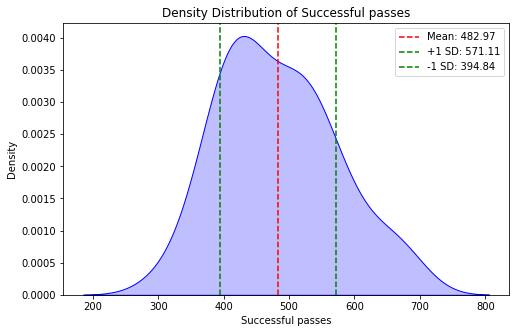

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


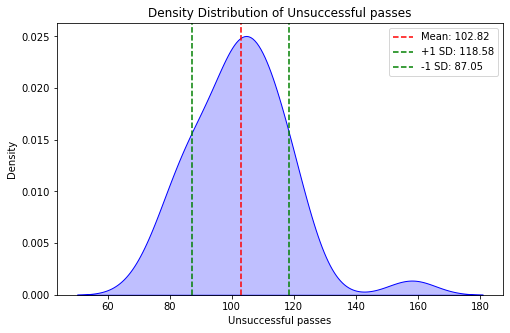

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


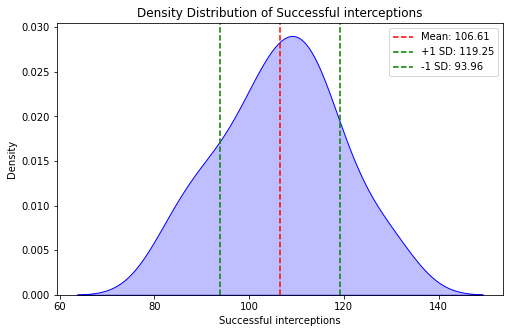

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


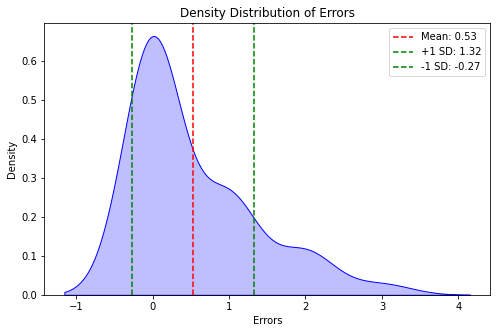

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


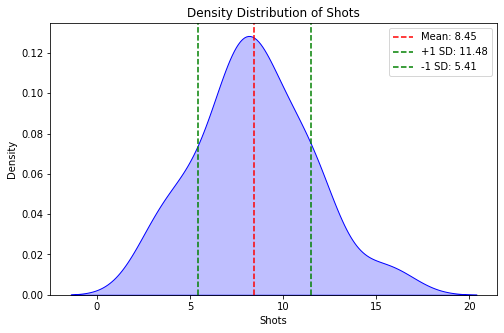

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


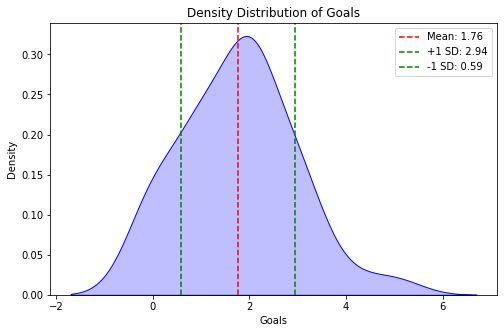

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/834963726.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')


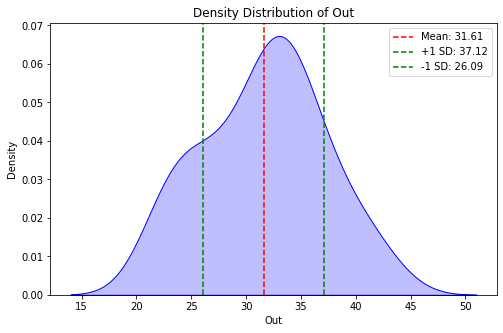

In [799]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to plot
columns = ['Successful passes', 'Unsuccessful passes', 'Successful interceptions',
           'Errors', 'Shots', 'Goals', 'Out']

# Create separate density plots for each column
for col in columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df_ManCity_info[col], shade=True, color='blue')
    
    # Calculate mean and standard deviation
    mean = df_ManCity_info[col].mean()
    std = df_ManCity_info[col].std()
    
    # Add lines for mean and standard deviation
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std, color='green', linestyle='--', label=f'+1 SD: {mean + std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='--', label=f'-1 SD: {mean - std:.2f}')
    
    # Add labels and title
    plt.title(f'Density Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()



/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}')
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {simulated_event}')


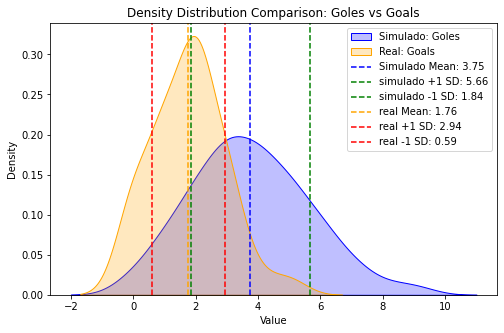

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}')
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {simulated_event}')


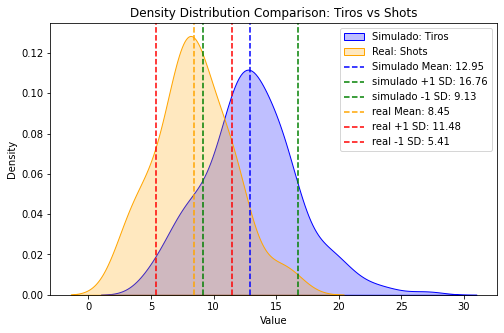

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}')
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {simulated_event}')


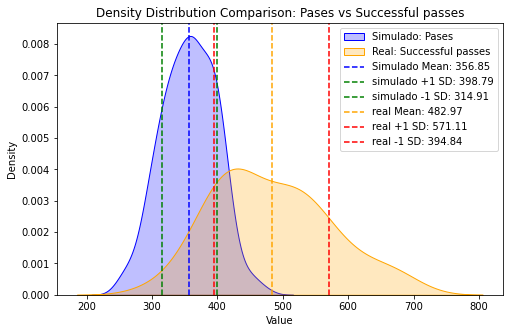

/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}')
/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_817/1114077017.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {simulated_event}')


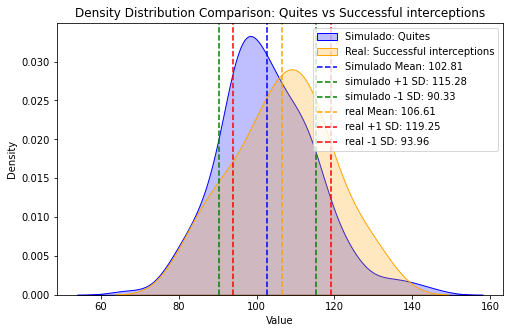

In [800]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the pairs of related events to be overlapped
event_pairs = [
    ('Goles', 'Goals'),
    ('Tiros', 'Shots'),
    ('Pases', 'Successful passes'),
    ('Quites', 'Successful interceptions')
]

# Loop through each pair and create overlapping density plots
for real_event, simulated_event in event_pairs:
    plt.figure(figsize=(8, 5))
    
    # Plot density for the real event from eventos_dict
    sns.kdeplot(eventos_dict[real_event], shade=True, color='blue', label=f'Simulado: {real_event.capitalize()}')
    
    # Plot density for the simulated event from df_ManCity_info
    sns.kdeplot(df_ManCity_info[simulated_event], shade=True, color='orange', label=f'Real: {simulated_event}')
    
    # Calculate means and standard deviations
    real_mean = eventos_dict[real_event].mean()
    real_std = eventos_dict[real_event].std()
    simulated_mean = df_ManCity_info[simulated_event].mean()
    simulated_std = df_ManCity_info[simulated_event].std()
    
    # Add vertical lines for the real event
    plt.axvline(real_mean, color='blue', linestyle='--', label=f'Simulado Mean: {real_mean:.2f}')
    plt.axvline(real_mean + real_std, color='green', linestyle='--', label=f'simulado +1 SD: {real_mean + real_std:.2f}')
    plt.axvline(real_mean - real_std, color='green', linestyle='--', label=f'simulado -1 SD: {real_mean - real_std:.2f}')
    
    # Add vertical lines for the simulated event
    plt.axvline(simulated_mean, color='orange', linestyle='--', label=f'real Mean: {simulated_mean:.2f}')
    plt.axvline(simulated_mean + simulated_std, color='red', linestyle='--', label=f'real +1 SD: {simulated_mean + simulated_std:.2f}')
    plt.axvline(simulated_mean - simulated_std, color='red', linestyle='--', label=f'real -1 SD: {simulated_mean - simulated_std:.2f}')
    
    # Add labels and title
    plt.title(f'Density Distribution Comparison: {real_event.capitalize()} vs {simulated_event}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
